<a href="https://colab.research.google.com/github/ashwinkd/US_Population_Flow_VGAE/blob/master/model_flow_cube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Andrej Baranovskij, http://katanaml.io/
# https://scikit-learn.org/stable/datasets/toy_dataset.html

# Importing the libraries
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

# Importing the Boston Housing dataset
from sklearn.datasets import load_boston

In [2]:
# Loading the Boston Housing dataset
boston = load_boston()

In [3]:
# Initializing the dataframe
data = pd.DataFrame(boston.data)

In [4]:
#Adding the feature names to the dataframe
data.columns = boston.feature_names

In [5]:
#Adding target variable to dataframe
data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
#Check the shape of dataframe
data.shape

(506, 14)

In [7]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'PRICE'],
      dtype='object')

In [8]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(data, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [9]:
# Helper functions
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop('PRICE')
    y1 = np.array(y1)
    y2 = data.pop('PTRATIO')
    y2 = np.array(y2)
    return y1, y2

In [10]:
# Get PRICE and PTRATIO as the 2 outputs and format them as np arrays
# PTRATIO - pupil-teacher ratio by town
train_stats = train.describe()
train_stats.pop('PRICE')
train_stats.pop('PTRATIO')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

print(train_stats)

       count        mean         std  ...        50%         75%       max
CRIM   323.0    3.882044    9.680410  ...    0.25387    3.944055   88.9762
ZN     323.0   12.233746   24.323780  ...    0.00000   19.000000  100.0000
INDUS  323.0   11.121796    6.876617  ...    8.56000   18.100000   27.7400
CHAS   323.0    0.080495    0.272481  ...    0.00000    0.000000    1.0000
NOX    323.0    0.553683    0.118625  ...    0.53200    0.624000    0.8710
RM     323.0    6.276935    0.691051  ...    6.19300    6.666500    8.7800
AGE    323.0   68.279876   28.452257  ...   77.70000   93.900000  100.0000
DIS    323.0    3.864749    2.154972  ...    3.36030    5.237900   12.1265
RAD    323.0    9.721362    8.801984  ...    5.00000   24.000000   24.0000
TAX    323.0  406.588235  170.365557  ...  329.00000  666.000000  711.0000
B      323.0  359.145604   89.252050  ...  391.93000  396.100000  396.9000
LSTAT  323.0   12.733529    7.251569  ...   11.45000   17.155000   37.9700

[12 rows x 8 columns]


In [11]:
# Normalize the training and test data
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [12]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    first_dense = Dense(units='128', activation='relu')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='price_output')(first_dense)

    second_dense = Dense(units='128', activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(units='1', name='ptratio_output')(second_dense)

    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

    return model

In [13]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'price_output': 'mse', 'ptratio_output': 'mse'},
              metrics={'price_output': tf.keras.metrics.RootMeanSquaredError(),
                       'ptratio_output': tf.keras.metrics.RootMeanSquaredError()})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
# Train the model for 100 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=100, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 528.9809 - price_output_loss: 366.2355 - ptratio_output_loss: 162.7454 - price_output_root_mean_squared_error: 19.1373 - ptratio_output_root_mean_squared_error: 12.7572 - val_loss: 166.0057 - val_price_output_loss: 146.1604 - val_ptratio_output_loss: 19.8453 - val_price_output_root_mean_squared_error: 12.0897 - val_ptratio_output_root_mean_squared_error: 4.4548
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 79.7197 - price_output_loss: 66.3140 - ptratio_output_loss: 13.4057 - price_output_root_mean_squared_error: 8.1433 - ptratio_output_root_mean_squared_error: 3.6614 - val_loss: 58.2312 - val_price_output_loss: 49.4277 - val_ptratio_output_loss: 8.8035 - val_price_output_root_mean_squared_error: 7.0305 - val_ptratio_output_root_mean_squared_error: 2.9671
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 41.9682 - price_output_loss: 35.0322 - ptratio_output_loss: 6.

In [15]:
# Test the model and print loss and rmse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'price_loss: {Y1_loss}')
print(f'ptratio_loss: {Y2_loss}')
print(f'price_rmse: {Y1_rmse}')
print(f'ptratio_rmse: {Y2_rmse}')

3/3 [==============================] - 0s 8ms/step - loss: 14.2165 - price_output_loss: 12.1776 - ptratio_output_loss: 2.0389 - price_output_root_mean_squared_error: 3.4896 - ptratio_output_root_mean_squared_error: 1.4279

loss: 14.216529846191406
price_loss: 12.177634239196777
ptratio_loss: 2.038896083831787
price_rmse: 3.4896466732025146
ptratio_rmse: 1.4278992414474487


In [16]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

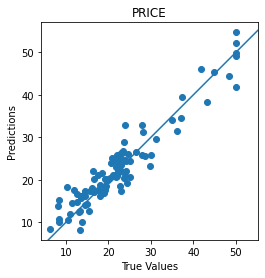

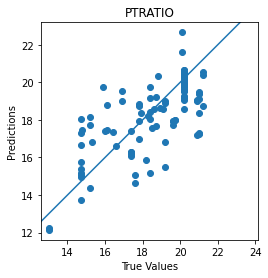

In [17]:
# Run predict
Y_pred = model.predict(norm_test_X)
price_pred = Y_pred[0]
ptratio_pred = Y_pred[1]

plot_diff(test_Y[0], Y_pred[0], title='PRICE')
plot_diff(test_Y[1], Y_pred[1], title='PTRATIO')

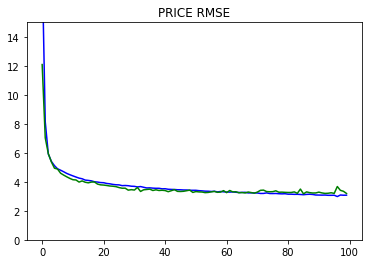

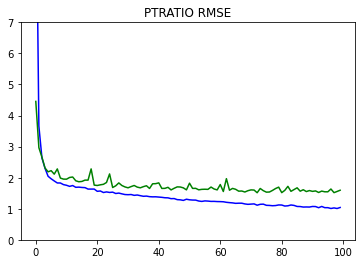

In [18]:
# Plot RMSE
plot_metrics(metric_name='price_output_root_mean_squared_error', title='PRICE RMSE', ylim=15)
plot_metrics(metric_name='ptratio_output_root_mean_squared_error', title='PTRATIO RMSE', ylim=7)

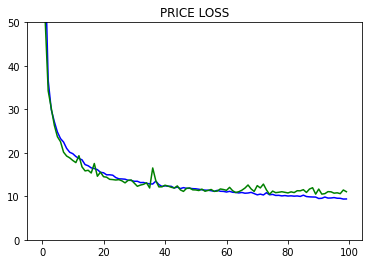

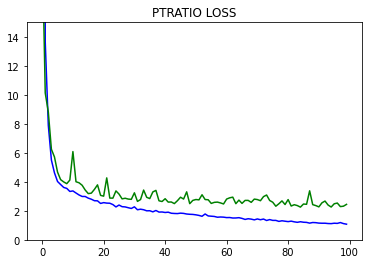

In [ ]:
# Plot loss
plot_metrics(metric_name='price_output_loss', title='PRICE LOSS', ylim=50)
plot_metrics(metric_name='ptratio_output_loss', title='PTRATIO LOSS', ylim=15)

In [19]:
# Save model
model.save('./model_boston/', save_format='tf')

INFO:tensorflow:Assets written to: ./model_boston/assets


In [20]:
# Restore model
loaded_model = tf.keras.models.load_model('./model_boston/')

In [21]:
# Run predict with restored model
predictions = loaded_model.predict(norm_test_X)
price_pred = predictions[0]
ptratio_pred = predictions[1]